In [20]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --upgrade opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [23]:
!git clone https://github.com/EscVM/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (422/422), 34.08 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [24]:
!pip3 install -r OIDv4_ToolKit/requirements.txt

In [25]:
import os
from pprint import pprint
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import models
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [26]:
!python OIDv4_ToolKit/main.py downloader --y --classes Ambulance Bus Car Truck --type_csv train --limit 350


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading Ambulance.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Automatic download.
...145%, 0 MB, 11197 KB/s, 0 seconds passed
[DOWNLOAD] | File class-descriptions-boxable.c

In [27]:
!python OIDv4_ToolKit/main.py downloader --y --classes Ambulance Bus Car Truck --type_csv test --limit 350


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading Ambulance.
   [ERROR] | Missing the test-annotations-bbox.csv file.
[DOWNLOAD] | Automatic download.
...100%, 49 MB, 107833 KB/s, 0 seconds passed
[DOWNLOAD] | File test-annotations-bbox.csv downl

In [42]:
!python OIDv4_ToolKit/main.py downloader --y --classes Ambulance Bus Car Truck --type_csv validation --limit 350


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading Ambulance.
   [ERROR] | Missing the validation-annotations-bbox.csv file.
[DOWNLOAD] | Automatic download.
...100%, 16 MB, 9284 KB/s, 1 seconds passed
[DOWNLOAD] | File validation-annotations-bbox

In [70]:
# Training Dataset Normalize and Augmentation
train_datagen=ImageDataGenerator(
    rescale=(1/255.),
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=40,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    #fill_mode="nearest"
    )

test_datagen=ImageDataGenerator(
    rescale=(1/255.)
    )

validation_datagen=ImageDataGenerator(
    rescale=(1/255.)
    )

traindir = "OID/Dataset/train" 
testdir = "OID/Dataset/test"
valtdir = "OID/Dataset/validation"

train_generator=train_datagen.flow_from_directory(
    traindir,
    target_size =(224, 224),
    class_mode='categorical',
    batch_size=32
    )

test_generator=test_datagen.flow_from_directory(
    testdir,
    target_size =(224, 224),
    class_mode='categorical',
    batch_size=32
    )

validation_generator=test_datagen.flow_from_directory(
    valtdir,
    target_size =(224, 224),
    class_mode='categorical',
    batch_size=32
    )

class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_generator.classes),
    train_generator.classes
    )

print(train_generator.labels)
print(train_generator.class_indices)
print(class_weights)

Found 1388 images belonging to 4 classes.
Found 998 images belonging to 4 classes.
Found 704 images belonging to 4 classes.
[0 0 0 ... 3 3 3]
{'Ambulance': 0, 'Bus': 1, 'Car': 2, 'Truck': 3}
[1.02662722 0.99142857 0.99142857 0.99142857]


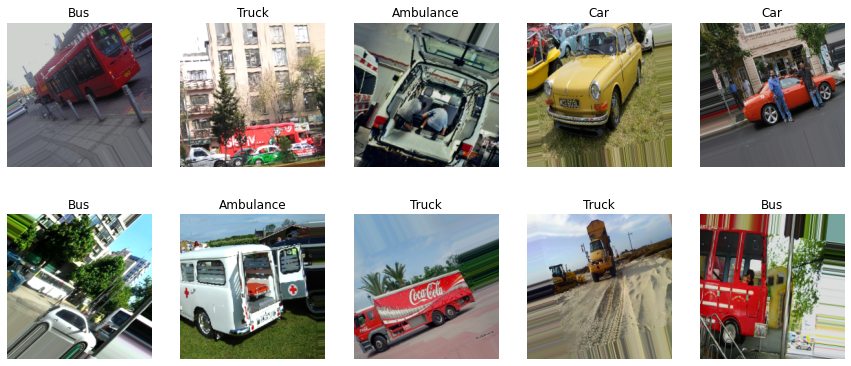

In [71]:
target_labels = next(os.walk(traindir))[1]

target_labels.sort()

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

In [34]:
IMG_SIZE = (224,224)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [35]:
base_model.summary()
len(base_model.layers)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

154

In [54]:
image_batch, label_batch = next(iter(train_generator))

feature_batch = base_model(image_batch)

#Freeze the convolutional layers
base_model.trainable = False

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)

# prediction_layer = tf.keras.layers.Dense(5)
# prediction_batch = prediction_layer(feature_batch_average)

#Model Building
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])
# inputs = tf.keras.Input(shape=( 224, 224, 3))
# x = base_model(inputs, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)


# print(feature_batch.shape)
# print(feature_batch_average.shape)
# print(prediction_batch.shape)

In [55]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 2,915,908
Trainable params: 657,924
Non-trainable params: 2,257,984
_________________________________________________________________


In [57]:
initial_epochs = 10

In [72]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator)

Epoch 1/10
44/44 [==============================] - 111s 3s/step - loss: 0.6569 - accuracy: 0.7435 - val_loss: 0.7090 - val_accuracy: 0.7614
Epoch 2/10
44/44 [==============================] - 111s 3s/step - loss: 0.6705 - accuracy: 0.7298 - val_loss: 0.7293 - val_accuracy: 0.7543
Epoch 3/10
44/44 [==============================] - 113s 3s/step - loss: 0.6460 - accuracy: 0.7385 - val_loss: 0.7257 - val_accuracy: 0.7528
Epoch 4/10
44/44 [==============================] - 112s 3s/step - loss: 0.6634 - accuracy: 0.7428 - val_loss: 0.6872 - val_accuracy: 0.7656
Epoch 5/10
44/44 [==============================] - 112s 3s/step - loss: 0.6310 - accuracy: 0.7478 - val_loss: 0.6992 - val_accuracy: 0.7656
Epoch 6/10
44/44 [==============================] - 112s 3s/step - loss: 0.6252 - accuracy: 0.7565 - val_loss: 0.6780 - val_accuracy: 0.7741
Epoch 7/10
44/44 [==============================] - 112s 3s/step - loss: 0.6319 - accuracy: 0.7558 - val_loss: 0.6651 - val_accuracy: 0.7741
Epoch 8/10
44

In [73]:
#Un-Freeze Top Layer
base_model.trainable = True

# Total Layer on Based Model
print("Total Layer on Based Model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 139

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Total Layer on Based Model:  154


In [74]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 2,915,908
Trainable params: 1,697,924
Non-trainable params: 1,217,984
_________________________________________________________________


In [76]:
fine_tune_epochs = 180
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 10/190
44/44 [==============================] - 119s 3s/step - loss: 0.6079 - accuracy: 0.7445 - val_loss: 0.6578 - val_accuracy: 0.7827
Epoch 11/190
44/44 [==============================] - 111s 3s/step - loss: 0.6135 - accuracy: 0.7621 - val_loss: 0.6504 - val_accuracy: 0.7912
Epoch 12/190
44/44 [==============================] - 111s 3s/step - loss: 0.6078 - accuracy: 0.7696 - val_loss: 0.6391 - val_accuracy: 0.7926
Epoch 13/190
44/44 [==============================] - 110s 3s/step - loss: 0.6193 - accuracy: 0.7614 - val_loss: 0.6360 - val_accuracy: 0.7955
Epoch 14/190
44/44 [==============================] - 111s 3s/step - loss: 0.6095 - accuracy: 0.7439 - val_loss: 0.6294 - val_accuracy: 0.7983
Epoch 15/190
44/44 [==============================] - 111s 3s/step - loss: 0.5947 - accuracy: 0.7754 - val_loss: 0.6466 - val_accuracy: 0.7969
Epoch 16/190
44/44 [==============================] - 112s 3s/step - loss: 0.5902 - accuracy: 0.7748 - val_loss: 0.6378 - val_accuracy: 0.7940

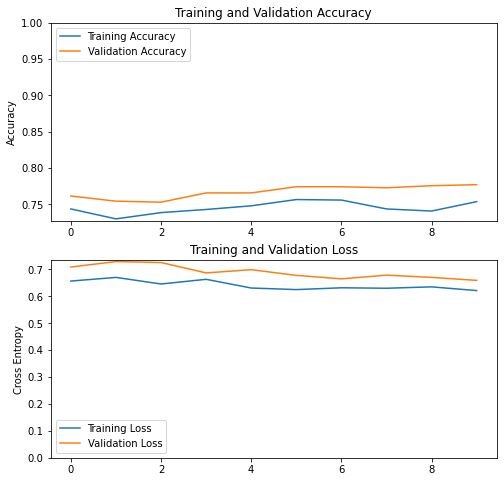

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [80]:
model.save_weights('Checkpoint/Ambulance_checkpoint')

In [81]:
model.save('Model/TheATeam_model')

INFO:tensorflow:Assets written to: Model/TheATeam_model/assets


In [82]:
model.save('TheATeam_model.h5')